In [8]:
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt

In [9]:
#connect my db with sql database
conn = sqlite3.connect('superstore_database.db')
cursor = conn.cursor()

In [10]:
sql_query = """
    select c.CustomerName, c.State, count(*) from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID group by  c.CustomerName order by count(*) desc limit 10 
"""
pd.read_sql(sql_query, conn)

,CustomerName,State,count(*)
0,William Brown,Pennsylvania,37
1,Paul Prost,Georgia,34
2,Matt Abelman,Texas,34
3,John Lee,California,34
4,Seth Vernon,Delaware,32
5,Jonathan Doherty,Pennsylvania,32
6,Edward Hooks,New York,32
7,Chloris Kastensmidt,Pennsylvania,32
8,Zuschuss Carroll,Oregon,31
9,Emily Phan,Illinois,31


In [11]:
sql_query = """
    select c.CustomerName, c.State, count(*) from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID group by  c.State order by count(*) desc limit 10 
"""
pd.read_sql(sql_query, conn)

,CustomerName,State,count(*)
0,Darrin Van Huff,California,1998
1,Janet Molinari,New York,1110
2,Harold Pawlan,Texas,917
3,Sandra Flanagan,Pennsylvania,641
4,Linda Cazamias,Illinois,574
5,Ryan Crowe,Ohio,480
6,Irene Maddox,Washington,460
7,Andrew Allen,North Carolina,343
8,Brendan Sweed,Arizona,301
9,Sean O'Donnell,Florida,290


In [12]:
most_sales = """ 
select  c.State, sum(s.sales) as total_sales from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID  group by c.State order by sum(s.Sales) DESC limit 5

"""
pd.read_sql(most_sales,conn)


,State,total_sales
0,California,451036.5823
1,New York,279549.8235
2,Texas,192758.2049
3,Pennsylvania,142838.5510
4,Washington,133177.2518


In [13]:
most_sales = """ 

WITH state_sales AS (
    SELECT
        c.State,
        SUM(s.sales) AS total_sales
    FROM
        customers c
        JOIN orders o ON c.CustomerID = o.CustomerID
        JOIN sales s ON o.OrderID = s.OrderID
    GROUP BY
        c.State
),
ranked_states AS (
    SELECT
        State,
        total_sales,
        RANK() OVER (ORDER BY total_sales DESC) AS rank_desc,
        RANK() OVER (ORDER BY total_sales ASC) AS rank_asc
    FROM
        state_sales
)
SELECT
    State,
    total_sales,
    rank_desc AS state_rank
FROM
    ranked_states
WHERE
    rank_desc <= 5
UNION ALL
SELECT
    State,
    total_sales,
    rank_asc AS state_rank
FROM
    ranked_states
WHERE
    rank_asc <= 5
ORDER BY
    state_rank;


"""
most_least_sales = pd.read_sql(most_sales,conn)

In [14]:
most_least_sales=most_least_sales.sort_values(by="total_sales")
sales_data= most_least_sales
sales_data

,State,total_sales,state_rank
1,Nevada,1214.9860,1
3,Maryland,1588.8100,2
5,Kansas,1727.6520,3
7,District of Columbia,2198.4500,4
9,South Dakota,2339.5980,5
8,Washington,133177.2518,5
6,Pennsylvania,142838.5510,4
4,Texas,192758.2049,3
2,New York,279549.8235,2
0,California,451036.5823,1


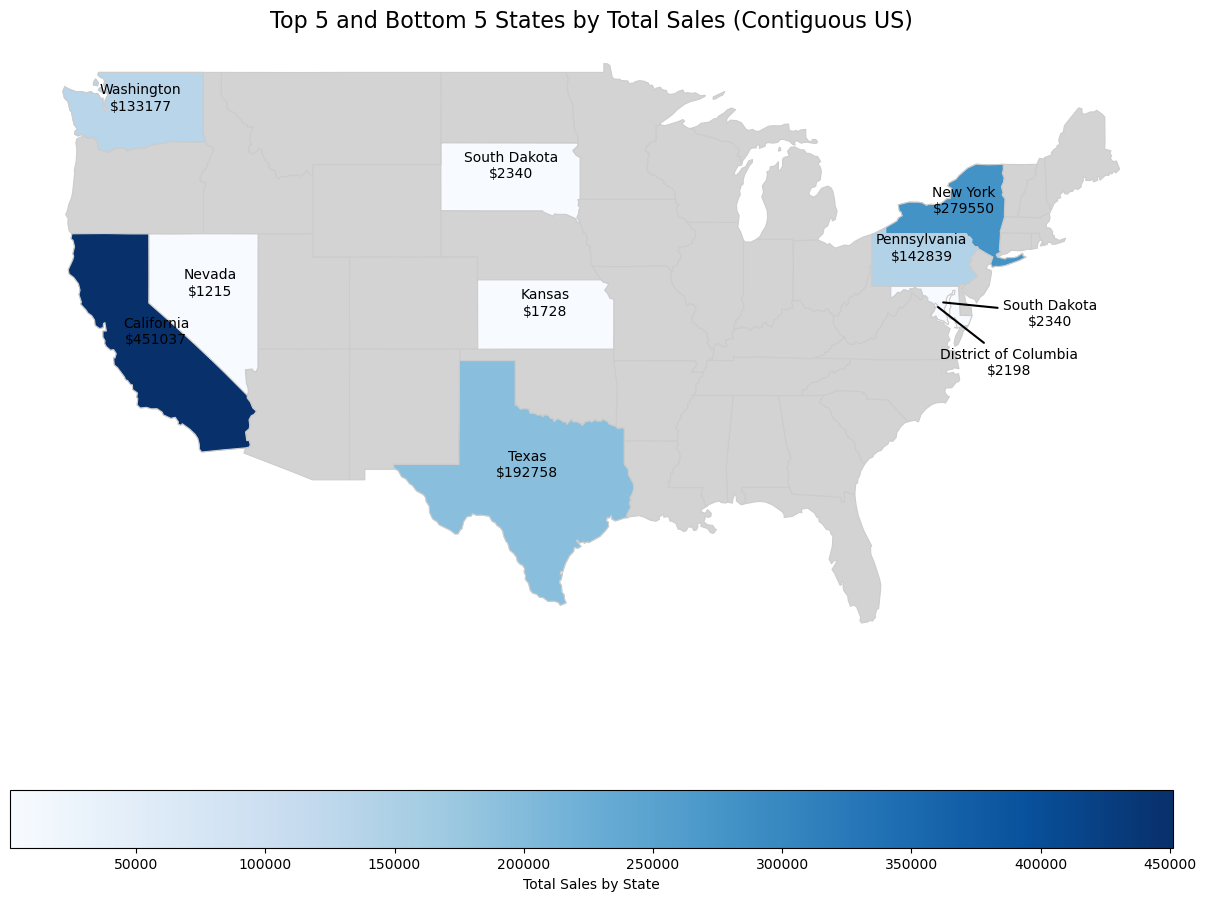

In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt




# Get top 5 and bottom 5 states by sales
top_5 = sales_data.nlargest(5, 'total_sales')
bottom_5 = sales_data.nsmallest(5, 'total_sales')

# Combine top 5 and bottom 5 into a single DataFrame
selected_states = pd.concat([top_5, bottom_5])

# Load US states shapefile (GeoJSON for US states)
states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')

# Filter out Alaska, Hawaii, and other non-contiguous areas
contiguous_states = states[~states['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Merge the sales data with the GeoDataFrame
merged = contiguous_states.set_index('name').join(selected_states.set_index('State'))

# Create a new column for color; fill with 'lightgrey' for states without data
merged['color'] = merged['total_sales'].apply(lambda x: 'lightgrey' if pd.isna(x) else 'blue')

# Create a plot with matplotlib
fig, ax = plt.subplots(1, 1, figsize=(15, 12))  # Adjusted to make the map larger

# Plot the states, but color only those with 'total_sales' data
merged.plot(ax=ax, color='lightgrey', linewidth=0.8, edgecolor='0.8')  # Grey for other states

# Plot only the selected states (top 5 and bottom 5) with color mapping
merged[~merged['total_sales'].isna()].plot(column='total_sales', ax=ax, cmap='Blues', linewidth=0.8, edgecolor='0.8', 
                                           legend=True, legend_kwds={'label': "Total Sales by State", 
                                                                     'orientation': "horizontal"})

# Add labels for total_sales and state names on each state
for idx, row in merged.iterrows():
    if pd.notna(row['total_sales']) and idx not in ['Maryland', 'District of Columbia']:  # Skip South Dakota and DC
        ax.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
                f"{idx}\n${row['total_sales']:.0f}", fontsize=10, ha='center', color='black')

# Move South Dakota and District of Columbia labels outside the map
outside_labels = {
    'South Dakota': {'xy': (merged.loc['Maryland'].geometry.centroid.x, merged.loc['Maryland'].geometry.centroid.y),
                     'text': (merged.loc['Maryland'].geometry.centroid.x + 6, merged.loc['Maryland'].geometry.centroid.y - 1)},
    'District of Columbia': {'xy': (merged.loc['District of Columbia'].geometry.centroid.x, merged.loc['District of Columbia'].geometry.centroid.y),
                             'text': (merged.loc['District of Columbia'].geometry.centroid.x + 4, merged.loc['District of Columbia'].geometry.centroid.y - 3)}
}

for state, pos in outside_labels.items():
    # Draw the callout line
    ax.annotate(f"{state}\n${merged.loc[state, 'total_sales']:.0f}", 
                xy=pos['xy'],  # Coordinates of the state
                xytext=pos['text'],  # Position of the label outside
                textcoords='data',
                arrowprops=dict(facecolor='black', arrowstyle='-', lw=1.5),  # Line style
                fontsize=10, ha='center', color='black')

# Set the title
ax.set_title('Top 5 and Bottom 5 States by Total Sales (Contiguous US)', fontsize=16)

# Remove axes for cleaner visualization
ax.set_axis_off()

# Show the plot
plt.show()

In [16]:
customer_growth = """
WITH cte AS (
  SELECT 
      o.OrderDate,
      SUM(s.Sales) AS Sales,
      CAST(CASE 
           WHEN INSTR(o.OrderDate, '/') = 2 THEN SUBSTR(o.OrderDate, 1, 1)
           ELSE SUBSTR(o.OrderDate, 1, 2) 
           END AS INTEGER) AS month
  FROM sales s
  JOIN orders o ON s.OrderID = o.OrderID
  GROUP BY month
)
SELECT 
    OrderDate, 
    Sales, 
    month AS extracted_month,
    ROUND(
    CASE 
        WHEN month = 1 THEN 
            ((Sales - (SELECT Sales FROM cte WHERE month = 12)) * 1.0 / (SELECT Sales FROM cte WHERE month = 12)) * 100
        ELSE 
            ((Sales - LAG(Sales) OVER (ORDER BY month ASC)) * 1.0 / LAG(Sales) OVER (ORDER BY month ASC)) * 100
    END, 
2) AS percentage_change
FROM cte 
ORDER BY extracted_month;
"""

total_sales = pd.read_sql(customer_growth, conn)

total_sales["name_month"]= pd.to_datetime(total_sales["extracted_month"], format="%m").dt.strftime("%B")
total_sales

,OrderDate,Sales,extracted_month,percentage_change,name_month
0,1/16/2016,94924.8356,1,-70.82,January
1,2/2/2017,59751.2514,2,-37.05,February
2,3/11/2016,205005.4888,3,243.10,March
3,4/15/2017,137762.1286,4,-32.80,April
4,5/13/2014,155028.8117,5,12.53,May
5,6/12/2016,152718.6793,6,-1.49,June
6,7/16/2017,147238.0970,7,-3.59,July
7,8/27/2014,159044.0630,8,8.02,August
8,9/25/2015,307649.9457,9,93.44,September
9,10/11/2015,200322.9847,10,-34.89,October


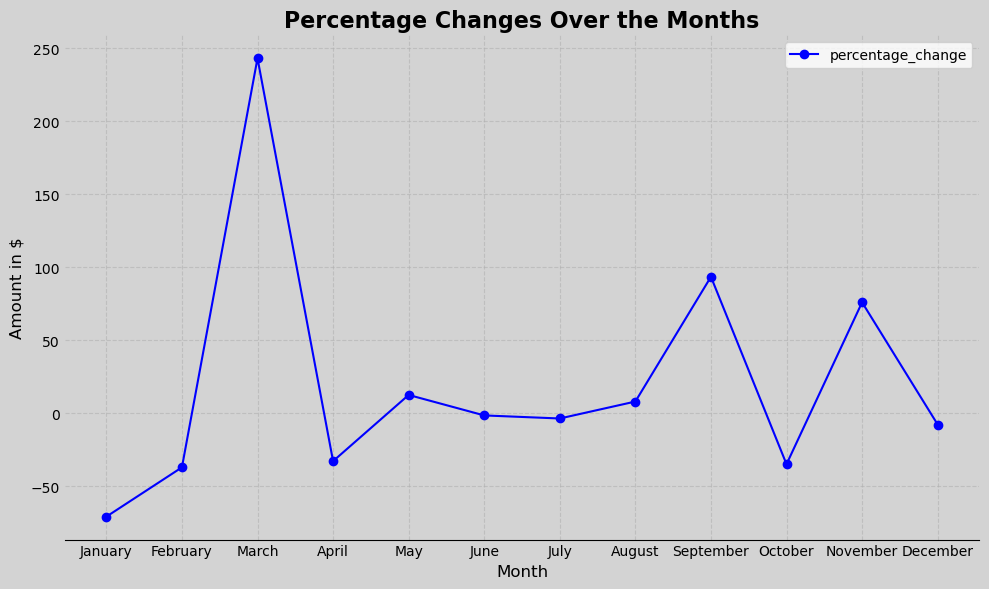

In [17]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line for profit
ax.plot(total_sales['name_month'], total_sales['percentage_change'], label='percentage_change', color='blue', marker='o')



# Adding labels and title
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Amount in $', fontsize=12)
ax.set_title('Percentage Changes Over the Months', fontsize=16, fontweight='bold')

# Customize x-tick labels
ax.set_xticks(total_sales['name_month'])  # Ensure that all years are marked on the x-axis

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Customize tick parameters for better visualization
ax.tick_params(axis='both', which='major', labelsize=10)

# Add a legend to distinguish between Profit and Purchases
ax.legend()
# Remove top and right spines (black borders)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add gridlines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Change the background color of the plot and figure
ax.set_facecolor('lightgrey')  # Set the plot background color
fig.set_facecolor('lightgrey')  # Set the figure background color

# Customize tick parameters (no ticks on the axes lines)
ax.tick_params(axis='both', which='both', length=0)
# Show the plot
plt.tight_layout()
plt.show()

In [18]:
customer_growth = """
WITH cte AS (
  SELECT 
      o.OrderDate,
      count(distinct c.CustomerID) as New_Customer,
      CAST(CASE 
           WHEN INSTR(o.OrderDate, '/') = 2 THEN SUBSTR(o.OrderDate, 1, 1)
           ELSE SUBSTR(o.OrderDate, 1, 2) 
           END AS INTEGER) AS month
  FROM customers c
  JOIN orders o ON c.CustomerID = o.CustomerID
  GROUP BY month
  
)
SELECT 
  
    New_Customer, 
    month AS extracted_month,
    ROUND(
    CASE 
        WHEN month = 1 THEN 
            ((New_Customer - (SELECT New_Customer FROM cte WHERE month = 12)) * 1.0 / (SELECT New_Customer FROM cte WHERE month = 12)) * 100
        ELSE 
            ((New_Customer - LAG(New_Customer) OVER (ORDER BY month ASC)) * 1.0 / LAG(New_Customer) OVER (ORDER BY month ASC)) * 100
    END, 
2) AS percentage_change
FROM cte 
GROUP BY extracted_month
ORDER BY extracted_month;
"""

total_sales = pd.read_sql(customer_growth, conn)

total_sales["name_month"]= pd.to_datetime(total_sales["extracted_month"], format="%m").dt.strftime("%B")
total_sales

,New_Customer,extracted_month,percentage_change,name_month
0,159,1,-64.98,January
1,146,2,-8.18,February
2,290,3,98.63,March
3,282,4,-2.76,April
4,301,5,6.74,May
5,290,6,-3.65,June
6,281,7,-3.10,July
7,280,8,-0.36,August
8,459,9,63.93,September
9,323,10,-29.63,October


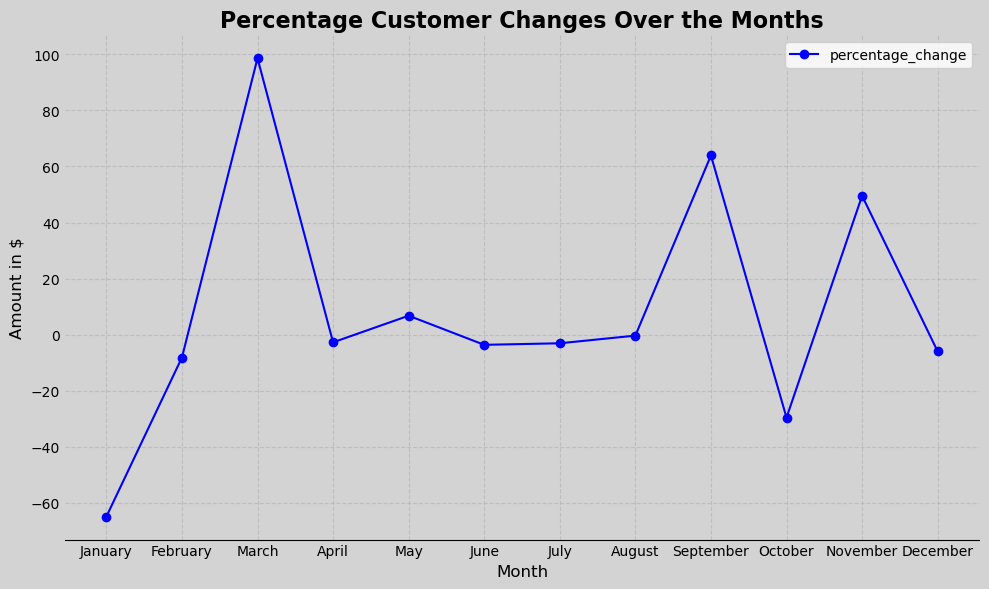

In [19]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line for profit
ax.plot(total_sales['name_month'], total_sales['percentage_change'], label='percentage_change', color='blue', marker='o')



# Adding labels and title
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Amount in $', fontsize=12)
ax.set_title('Percentage Customer Changes Over the Months', fontsize=16, fontweight='bold')

# Customize x-tick labels
ax.set_xticks(total_sales['name_month'])  # Ensure that all years are marked on the x-axis

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Customize tick parameters for better visualization
ax.tick_params(axis='both', which='major', labelsize=10)

# Add a legend to distinguish between Profit and Purchases
ax.legend()
# Remove top and right spines (black borders)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add gridlines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Change the background color of the plot and figure
ax.set_facecolor('lightgrey')  # Set the plot background color
fig.set_facecolor('lightgrey')  # Set the figure background color

# Customize tick parameters (no ticks on the axes lines)
ax.tick_params(axis='both', which='both', length=0)
# Show the plot
plt.tight_layout()
plt.show()

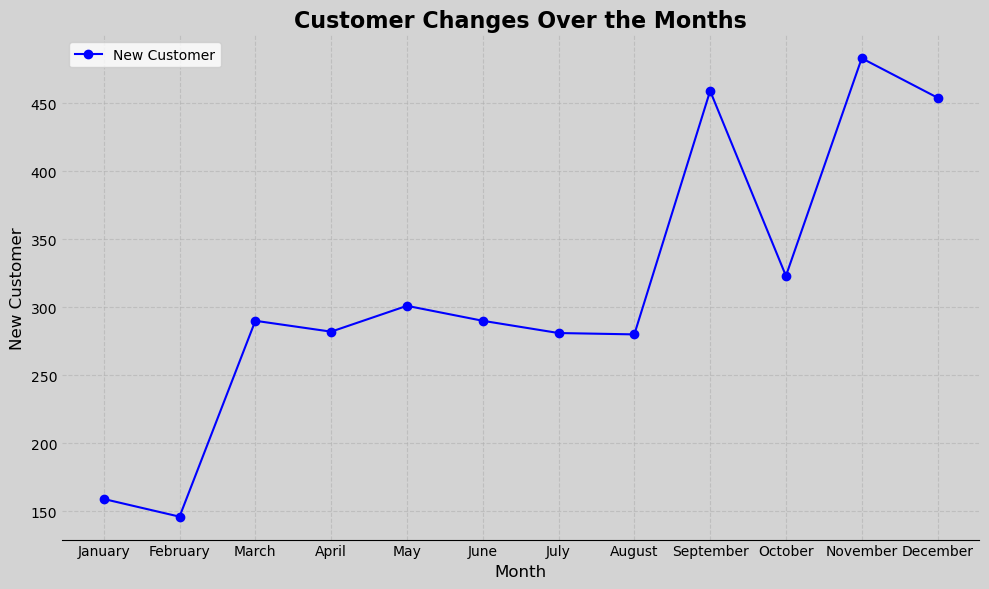

In [20]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line for profit
ax.plot(total_sales['name_month'], total_sales['New_Customer'], label='New Customer', color='blue', marker='o')



# Adding labels and title
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('New Customer', fontsize=12)
ax.set_title('Customer Changes Over the Months', fontsize=16, fontweight='bold')

# Customize x-tick labels
ax.set_xticks(total_sales['name_month'])  # Ensure that all years are marked on the x-axis

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Customize tick parameters for better visualization
ax.tick_params(axis='both', which='major', labelsize=10)

# Add a legend to distinguish between Profit and Purchases
ax.legend()
# Remove top and right spines (black borders)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add gridlines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Change the background color of the plot and figure
ax.set_facecolor('lightgrey')  # Set the plot background color
fig.set_facecolor('lightgrey')  # Set the figure background color

# Customize tick parameters (no ticks on the axes lines)
ax.tick_params(axis='both', which='both', length=0)
# Show the plot
plt.tight_layout()
plt.show()

In [51]:
customer_behv = """
  SELECT 
      c.CustomerName, 
      sum(s.Sales) as total_purchase,
      count(*) as total_order_count
     
  FROM customers c
  JOIN orders o  ON c.CustomerID = o.CustomerID 
  JOIN  sales s ON o.OrderID = s.OrderID
  GROUP BY c.CustomerID 
  ORDER BY sum(sales) DESC
"""
products_df = pd.read_sql(customer_behv, conn)
products_df.head(10)


,CustomerName,total_purchase,total_order_count
0,Sean Miller,25043.050,15
1,Tamara Chand,19052.218,12
2,Raymond Buch,15117.339,18
3,Tom Ashbrook,14595.620,10
4,Adrian Barton,14473.571,20
5,Ken Lonsdale,14175.229,29
6,Sanjit Chand,14142.334,22
7,Hunter Lopez,12873.298,11
8,Sanjit Engle,12209.438,19
9,Christopher Conant,12129.072,11


In [52]:
customer_behv = """
  SELECT 
      c.CustomerName, 
     p.ProductName,
     count(*),
     sum(s.Quantity),
     c.PostalCode
     
  FROM customers c
  JOIN orders o  ON c.CustomerID = o.CustomerID 
  JOIN  sales s ON o.OrderID = s.OrderID 
  JOIN products p ON s.ProductID = s.ProductID
  WHERE c.CustomerName = "Sean Miller"
  GROUP BY ProductName order by count(*) desc
 

 
"""
sean_miller = pd.read_sql(customer_behv, conn)
sean_miller

,CustomerName,ProductName,count(*),sum(s.Quantity),PostalCode
0,Sean Miller,netTALK DUO VoIP Telephone Service,15,50,28110
1,Sean Miller,invisibleSHIELD by ZAGG Smudge-Free Screen Pro...,15,50,28110
2,Sean Miller,iOttie XL Car Mount,15,50,28110
3,Sean Miller,iOttie HLCRIO102 Car Mount,15,50,28110
4,Sean Miller,iKross Bluetooth Portable Keyboard + Cell Phon...,15,50,28110
...,...,...,...,...,...
1813,Sean Miller,"#10- 4 1/8"" x 9 1/2"" Recycled Envelopes",15,50,28110
1814,Sean Miller,"#10 White Business Envelopes,4 1/8 x 9 1/2",15,50,28110
1815,Sean Miller,#10 Self-Seal White Envelopes,15,50,28110
1816,Sean Miller,"#10 Gummed Flap White Envelopes, 100/Box",15,50,28110


In [50]:
customer_behv = """
  SELECT 
      c.CustomerName, 
     p.ProductName,
     count(*),
     sum(s.Quantity),
     c.PostalCode
     
  FROM customers c
  JOIN orders o  ON c.CustomerID = o.CustomerID 
  JOIN  sales s ON o.OrderID = s.OrderID 
  JOIN products p ON s.ProductID = s.ProductID
  WHERE c.CustomerName = "Jasper Cacioppo"
  group by p.ProductName order by count(*) desc
 

 
"""
Tamara_Chand = pd.read_sql(customer_behv, conn)
Tamara_Chand

,CustomerName,ProductName,count(*),sum(s.Quantity),PostalCode
0,Jasper Cacioppo,netTALK DUO VoIP Telephone Service,4,12,90032
1,Jasper Cacioppo,invisibleSHIELD by ZAGG Smudge-Free Screen Pro...,4,12,90032
2,Jasper Cacioppo,iOttie XL Car Mount,4,12,90032
3,Jasper Cacioppo,iOttie HLCRIO102 Car Mount,4,12,90032
4,Jasper Cacioppo,iKross Bluetooth Portable Keyboard + Cell Phon...,4,12,90032
...,...,...,...,...,...
1813,Jasper Cacioppo,"#10- 4 1/8"" x 9 1/2"" Recycled Envelopes",4,12,90032
1814,Jasper Cacioppo,"#10 White Business Envelopes,4 1/8 x 9 1/2",4,12,90032
1815,Jasper Cacioppo,#10 Self-Seal White Envelopes,4,12,90032
1816,Jasper Cacioppo,"#10 Gummed Flap White Envelopes, 100/Box",4,12,90032


#### They are all wholesalers because they are buying same products just with different ammount. Every customer buy 1817 items